In [1]:
# import relevant libraries
from datetime import datetime
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn import metrics as sklMetrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from scipy import stats
plt.style.use('seaborn')
%matplotlib inline
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [2]:
# load in initial data - underlying futures contract prices
df1 = pd.read_csv('hgh21_intraday-1min_historical-data-02-01-2021.csv')
df2 = pd.read_csv('hgh21_intraday-1min_historical-data-02-02-2021.csv')

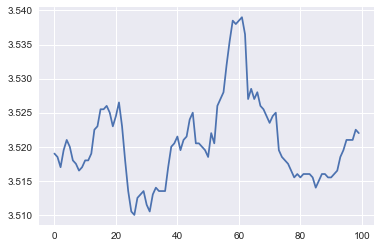

In [3]:
# graph of prices of last hundred trades
plt.plot(df2.index[:100], df2['High'][:100])

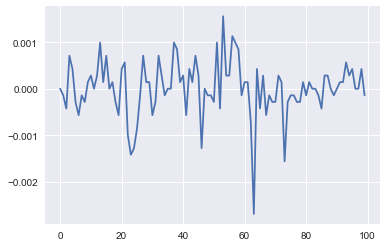

In [4]:
# graph of first derivative of last hundred trades
plt.plot(df2.index[:100], df2['High'][:100].diff().fillna(0)/df2['High'][:100])

In [5]:
# load in futures options price data
df3 = pd.read_csv('hgh21-options-american-options-exp-02_23_21-show-all-%futuresoptionsview%-intraday-02-02-2021.csv')
df3.head()

,Strike,High,Low,Last,Change,Bid,Ask,Volume,Open Int,Premium,Time
0,0.7500C,2.7965,2.7965,2.7965,-0.01,2.7615,2.7690,NaN,8.0,69912.5,02/01/21
1,0.7500P,0.0005,0.0005,0.0005,0.00,0.0000,0.0015,NaN,NaN,12.5,02/01/21
2,1.0000C,2.5465,2.5465,2.5465,-0.01,0.0000,0.0000,NaN,NaN,63662.5,02/01/21
3,1.0000P,0.0005,0.0005,0.0005,0.00,0.0000,0.0015,NaN,NaN,12.5,02/01/21
4,1.1000C,2.4465,2.4465,2.4465,-0.01,0.0000,0.0000,NaN,NaN,61162.5,02/01/21


In [6]:
# read in futures options greeks
df4 = pd.read_csv('hgh21-volatility-greeks-exp-02_23_21-show-all-02-02-2021.csv')
df4.columns = ['Strike', 'Last', 'IV', 'Delta', 'Gamma', 'Theta', 'Vega', 'IV_Skew', 'Type', 'Time', 'Symbol', 'to_drop']
df4.drop(columns=['to_drop'], inplace=True)
# split into calls and puts
df4_calls = df4[:142]
df4_puts = df4[142:-1]
print(len(df4_calls))
print(len(df4_puts))
df4_calls.head()

142
142


,Strike,Last,IV,Delta,Gamma,Theta,Vega,IV_Skew,Type,Time,Symbol
0,0.75,2.7965,268.32%,0.99996,6.173429e-194,-4.137548e-197,1.062396e-196,+245.75%,Call,Monday February 1st,HGH1|75C
1,1,2.5465,219.92%,0.99996,5.319742e-129,-3.580414e-132,9.154838e-132,+197.35%,Call,Monday February 1st,HGH1|100C
2,1.1,2.4465,204.10%,0.99996,2.102593e-110,-1.417108e-113,3.618390e-113,+181.53%,Call,Monday February 1st,HGH1|110C
3,1.15,2.3965,196.72%,0.99996,3.160714e-102,-2.131647e-105,5.439330e-105,+174.15%,Call,Monday February 1st,HGH1|115C
4,1.2,2.3465,189.69%,0.99996,1.078644e-94,-7.279112e-98,1.856258e-97,+167.12%,Call,Monday February 1st,HGH1|120C


In [7]:
# arrange so the greeks and the price data correspond
rows1 = []
for i in range(len(df4_calls)):
    rows1.append(df4_calls.iloc[i])
    rows1.append(df4_puts.iloc[i])
df5 = pd.DataFrame(rows1, columns=['Strike', 'Last', 'IV', 'Delta', 'Gamma', 'Theta', 'Vega', 'IV_Skew', 'Type', 'Time', 'Symbol'])
df5.reset_index(drop=True, inplace=True)
df5.head()

,Strike,Last,IV,Delta,Gamma,Theta,Vega,IV_Skew,Type,Time,Symbol
0,0.75,2.7965,268.32%,0.99996,6.173429e-194,-4.137548e-197,1.062396e-196,+245.75%,Call,Monday February 1st,HGH1|75C
1,0.75,0.0005,206.56%,0.00000,6.173429e-194,-4.137548e-197,1.062396e-196,+183.99%,Put,Monday February 1st,HGH1|75P
2,1,2.5465,219.92%,0.99996,5.319742e-129,-3.580414e-132,9.154838e-132,+197.35%,Call,Monday February 1st,HGH1|100C
3,1,0.0005,169.06%,0.00000,5.319742e-129,-3.580414e-132,9.154838e-132,+146.49%,Put,Monday February 1st,HGH1|100P
4,1.1,2.4465,204.10%,0.99996,2.102593e-110,-1.417108e-113,3.618390e-113,+181.53%,Call,Monday February 1st,HGH1|110C


In [8]:
df3.head()

,Strike,High,Low,Last,Change,Bid,Ask,Volume,Open Int,Premium,Time
0,0.7500C,2.7965,2.7965,2.7965,-0.01,2.7615,2.7690,NaN,8.0,69912.5,02/01/21
1,0.7500P,0.0005,0.0005,0.0005,0.00,0.0000,0.0015,NaN,NaN,12.5,02/01/21
2,1.0000C,2.5465,2.5465,2.5465,-0.01,0.0000,0.0000,NaN,NaN,63662.5,02/01/21
3,1.0000P,0.0005,0.0005,0.0005,0.00,0.0000,0.0015,NaN,NaN,12.5,02/01/21
4,1.1000C,2.4465,2.4465,2.4465,-0.01,0.0000,0.0000,NaN,NaN,61162.5,02/01/21


In [9]:
# strip irrelevant end of strike price
new_strike = []
for i in range(len(df3)):
    new_strike.append(df3.iloc[i]['Strike'][:4])
df3['Strike'] = new_strike

In [10]:
# remove unwanted last row
df3 = df3[:-1]
df3.fillna(value=0, inplace=True)
df5 = df5.astype({'Strike':'float64'})
df3 = df3.astype({'Strike':'float64'})

In [11]:
# visualize df
df3.head()

,Strike,High,Low,Last,Change,Bid,Ask,Volume,Open Int,Premium,Time
0,0.75,2.7965,2.7965,2.7965,-0.01,2.7615,2.7690,0.0,8.0,69912.5,02/01/21
1,0.75,0.0005,0.0005,0.0005,0.00,0.0000,0.0015,0.0,0.0,12.5,02/01/21
2,1.00,2.5465,2.5465,2.5465,-0.01,0.0000,0.0000,0.0,0.0,63662.5,02/01/21
3,1.00,0.0005,0.0005,0.0005,0.00,0.0000,0.0015,0.0,0.0,12.5,02/01/21
4,1.10,2.4465,2.4465,2.4465,-0.01,0.0000,0.0000,0.0,0.0,61162.5,02/01/21


In [12]:
# visualize df
df5.head()

,Strike,Last,IV,Delta,Gamma,Theta,Vega,IV_Skew,Type,Time,Symbol
0,0.75,2.7965,268.32%,0.99996,6.173429e-194,-4.137548e-197,1.062396e-196,+245.75%,Call,Monday February 1st,HGH1|75C
1,0.75,0.0005,206.56%,0.00000,6.173429e-194,-4.137548e-197,1.062396e-196,+183.99%,Put,Monday February 1st,HGH1|75P
2,1.00,2.5465,219.92%,0.99996,5.319742e-129,-3.580414e-132,9.154838e-132,+197.35%,Call,Monday February 1st,HGH1|100C
3,1.00,0.0005,169.06%,0.00000,5.319742e-129,-3.580414e-132,9.154838e-132,+146.49%,Put,Monday February 1st,HGH1|100P
4,1.10,2.4465,204.10%,0.99996,2.102593e-110,-1.417108e-113,3.618390e-113,+181.53%,Call,Monday February 1st,HGH1|110C


In [13]:
# synthesize dataframe containing price data and greeks
df6 = pd.concat([df3.drop(columns=['Time']), df5.drop(columns=['Strike', 'Last', 'Time', 'Symbol'])], axis=1)
df6.head()

,Strike,High,Low,Last,Change,Bid,Ask,Volume,Open Int,Premium,IV,Delta,Gamma,Theta,Vega,IV_Skew,Type
0,0.75,2.7965,2.7965,2.7965,-0.01,2.7615,2.7690,0.0,8.0,69912.5,268.32%,0.99996,6.173429e-194,-4.137548e-197,1.062396e-196,+245.75%,Call
1,0.75,0.0005,0.0005,0.0005,0.00,0.0000,0.0015,0.0,0.0,12.5,206.56%,0.00000,6.173429e-194,-4.137548e-197,1.062396e-196,+183.99%,Put
2,1.00,2.5465,2.5465,2.5465,-0.01,0.0000,0.0000,0.0,0.0,63662.5,219.92%,0.99996,5.319742e-129,-3.580414e-132,9.154838e-132,+197.35%,Call
3,1.00,0.0005,0.0005,0.0005,0.00,0.0000,0.0015,0.0,0.0,12.5,169.06%,0.00000,5.319742e-129,-3.580414e-132,9.154838e-132,+146.49%,Put
4,1.10,2.4465,2.4465,2.4465,-0.01,0.0000,0.0000,0.0,0.0,61162.5,204.10%,0.99996,2.102593e-110,-1.417108e-113,3.618390e-113,+181.53%,Call


In [14]:
# map calls and puts to zeros and ones
df6['Type'] = df6['Type'].map({'Call':0, 'Put':1})

In [15]:
# strip % character form IV
new_IV = []
for i in range(len(df6)):
    new_IV.append(df6.iloc[i]['IV'][:-1])
df6['IV'] = new_IV

In [16]:
# strip +/- and % sign from IV_Skew
new_IV = []
for i in range(len(df6)):
    new_IV.append(df6.iloc[i]['IV_Skew'][1:-1])
df6['IV_Skew'] = new_IV

In [17]:
# visualize df
df6.head()

,Strike,High,Low,Last,Change,Bid,Ask,Volume,Open Int,Premium,IV,Delta,Gamma,Theta,Vega,IV_Skew,Type
0,0.75,2.7965,2.7965,2.7965,-0.01,2.7615,2.7690,0.0,8.0,69912.5,268.32,0.99996,6.173429e-194,-4.137548e-197,1.062396e-196,245.75,0
1,0.75,0.0005,0.0005,0.0005,0.00,0.0000,0.0015,0.0,0.0,12.5,206.56,0.00000,6.173429e-194,-4.137548e-197,1.062396e-196,183.99,1
2,1.00,2.5465,2.5465,2.5465,-0.01,0.0000,0.0000,0.0,0.0,63662.5,219.92,0.99996,5.319742e-129,-3.580414e-132,9.154838e-132,197.35,0
3,1.00,0.0005,0.0005,0.0005,0.00,0.0000,0.0015,0.0,0.0,12.5,169.06,0.00000,5.319742e-129,-3.580414e-132,9.154838e-132,146.49,1
4,1.10,2.4465,2.4465,2.4465,-0.01,0.0000,0.0000,0.0,0.0,61162.5,204.10,0.99996,2.102593e-110,-1.417108e-113,3.618390e-113,181.53,0


In [18]:
# Segregate calls and puts into separate dfs
calls = df6.loc[df6['Type'] == 0]
puts = df6.loc[df6['Type'] == 1]
calls.reset_index(drop=True, inplace = True)
puts.reset_index(drop=True, inplace = True)

In [19]:
# visualize df
calls.head()

,Strike,High,Low,Last,Change,Bid,Ask,Volume,Open Int,Premium,IV,Delta,Gamma,Theta,Vega,IV_Skew,Type
0,0.75,2.7965,2.7965,2.7965,-0.01,2.7615,2.769,0.0,8.0,69912.5,268.32,0.99996,6.173429e-194,-4.137548e-197,1.062396e-196,245.75,0
1,1.00,2.5465,2.5465,2.5465,-0.01,0.0000,0.000,0.0,0.0,63662.5,219.92,0.99996,5.319742e-129,-3.580414e-132,9.154838e-132,197.35,0
2,1.10,2.4465,2.4465,2.4465,-0.01,0.0000,0.000,0.0,0.0,61162.5,204.10,0.99996,2.102593e-110,-1.417108e-113,3.618390e-113,181.53,0
3,1.15,2.3965,2.3965,2.3965,-0.01,0.0000,0.000,0.0,0.0,59912.5,196.72,0.99996,3.160714e-102,-2.131647e-105,5.439330e-105,174.15,0
4,1.20,2.3465,2.3465,2.3465,-0.01,0.0000,0.000,0.0,0.0,58662.5,189.69,0.99996,1.078644e-94,-7.279112e-98,1.856258e-97,167.12,0


In [20]:
#visualize df
puts.head()

,Strike,High,Low,Last,Change,Bid,Ask,Volume,Open Int,Premium,IV,Delta,Gamma,Theta,Vega,IV_Skew,Type
0,0.75,0.0005,0.0005,0.0005,0.0,0.0,0.0015,0.0,0.0,12.5,206.56,0.0,6.173429e-194,-4.137548e-197,1.062396e-196,183.99,1
1,1.00,0.0005,0.0005,0.0005,0.0,0.0,0.0015,0.0,0.0,12.5,169.06,0.0,5.319742e-129,-3.580414e-132,9.154838e-132,146.49,1
2,1.10,0.0005,0.0005,0.0005,0.0,0.0,0.0015,0.0,0.0,12.5,156.88,0.0,2.102593e-110,-1.417108e-113,3.618390e-113,134.31,1
3,1.15,0.0005,0.0005,0.0005,0.0,0.0,0.0015,0.0,0.0,12.5,151.25,0.0,3.160714e-102,-2.131647e-105,5.439330e-105,128.68,1
4,1.20,0.0005,0.0005,0.0005,0.0,0.0,0.0015,0.0,0.0,12.5,145.63,0.0,1.078644e-94,-7.279112e-98,1.856258e-97,123.06,1


In [21]:
# import SVD module
from sklearn.decomposition import TruncatedSVD

In [22]:
# produce both a scaled and a transformed set of calls data
calls = calls.astype('float64')
calls.drop(columns=['Type'], inplace=True)
scaler = MinMaxScaler()
scaler.fit(calls)
scaled_calls = scaler.transform(calls)
svd = TruncatedSVD()
svd.fit(scaled_calls)
transformed_calls = svd.transform(scaled_calls)
transformed_calls

array([[ 2.25637234,  1.44541392],
       [ 2.1262406 ,  1.2698961 ],
       [ 2.08780172,  1.20939329],
       [ 2.06914234,  1.17986429],
       [ 2.05085281,  1.15081235],
       [ 2.03293313,  1.12223748],
       [ 2.0152565 ,  1.09397611],
       [ 1.99783348,  1.06604186],
       [ 1.98060067,  1.03835296],
       [ 1.96366894,  1.01105264],
       [ 1.94692758,  0.98399744],
       [ 1.93037107,  0.95718088],
       [ 1.9139942 ,  0.93059604],
       [ 1.89781274,  0.90426347],
       [ 1.88174768,  0.87808061],
       [ 1.86587803,  0.85215002],
       [ 1.85012462,  0.82636937],
       [ 1.83449266,  0.80074559],
       [ 1.81898766,  0.77528513],
       [ 1.8036041 ,  0.74998154],
       [ 1.78834735,  0.72484152],
       [ 1.773154  ,  0.69978327],
       [ 1.75808746,  0.6748886 ],
       [ 1.74307375,  0.65006207],
       [ 1.72818685,  0.62539911],
       [ 1.71336335,  0.60081792],
       [ 1.69866666,  0.57640031],
       [ 1.68396997,  0.55198269],
       [ 1.66938952,

In [23]:
# produce both a scaled and a transformed set of puts data
puts = puts.astype('float64')
puts.drop(columns=['Type'], inplace=True)
scaler = MinMaxScaler()
scaler.fit(puts)
scaled_puts = scaler.transform(puts)
svd = TruncatedSVD()
svd.fit(scaled_puts)
transformed_puts = svd.transform(scaled_puts)
transformed_puts

array([[ 1.45397908, -0.77197069],
       [ 1.41396409, -0.72063567],
       [ 1.40201421, -0.70357878],
       [ 1.39670091, -0.69561752],
       [ 1.39140199, -0.68766859],
       [ 1.38676471, -0.68028685],
       [ 1.38212743, -0.67290512],
       [ 1.37818055, -0.66611523],
       [ 1.37421929, -0.65931301],
       [ 1.37025802, -0.65251079],
       [ 1.36668452, -0.6471138 ],
       [ 1.36339927, -0.6408911 ],
       [ 1.36012008, -0.63467612],
       [ 1.35746225, -0.6279159 ],
       [ 1.35423395, -0.62281484],
       [ 1.35162472, -0.61717166],
       [ 1.34963458, -0.61098636],
       [ 1.34736223, -0.6056345 ],
       [ 1.34542298, -0.60056311],
       [ 1.34315895, -0.59521585],
       [ 1.34122575, -0.59015218],
       [ 1.33962337, -0.58537211],
       [ 1.33769016, -0.58030845],
       [ 1.33637604, -0.57470267],
       [ 1.3347797 , -0.56993032],
       [ 1.33351647, -0.56543845],
       [ 1.33225929, -0.56095431],
       [ 1.3310021 , -0.55647016],
       [ 1.32988066,

In [24]:
# confirm common shape
print(transformed_puts.shape)
print(transformed_calls.shape)

(142, 2)
(142, 2)


In [25]:
# create scaled ([0,255]) call and put dataframes
s_c_df = pd.DataFrame(scaled_calls, columns=calls.columns)
s_c_df = s_c_df * 255
s_p_df = pd.DataFrame(scaled_puts, columns=puts.columns)
s_p_df = s_p_df * 255

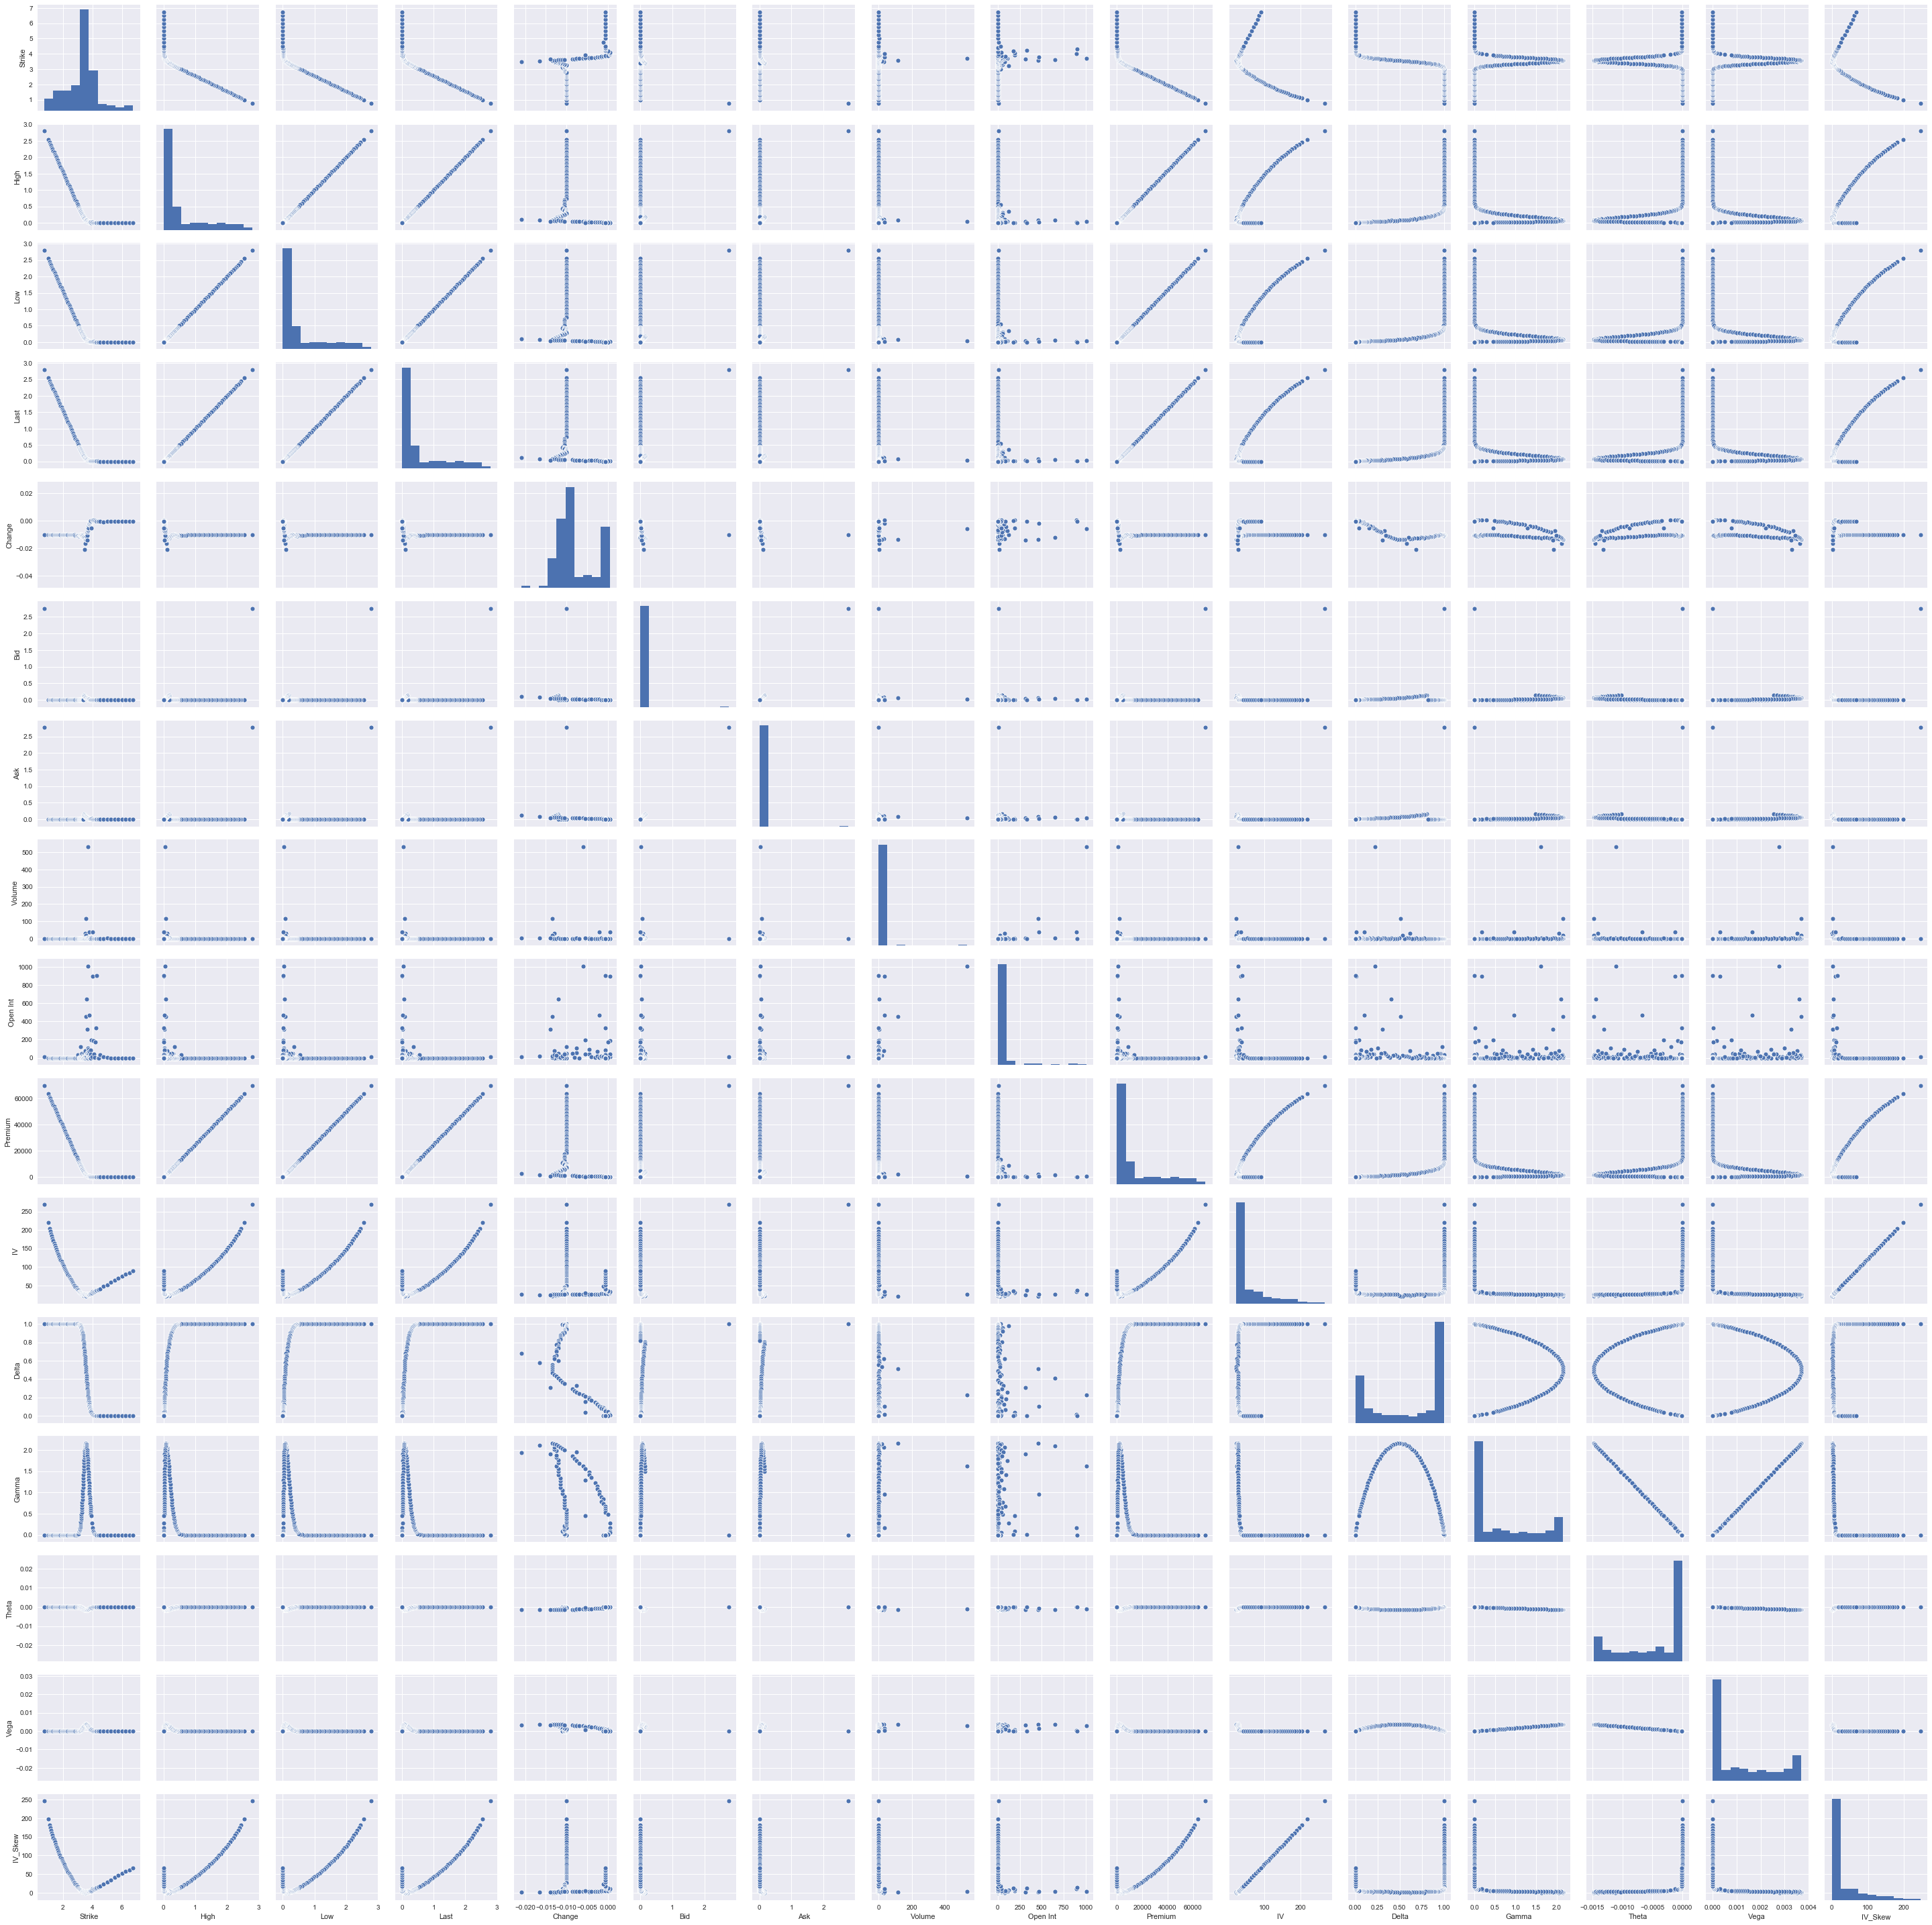

In [26]:
# visualize correlations
sns.pairplot(calls)

In [ ]:
# visualize correlations
sns.pairplot(puts)

In [ ]:
# revisit underlying security
df1.head()

In [ ]:
# remove time column
df1.drop(columns=['Time'])

In [ ]:
# ordinary least squares
lr_model = ols(formula='Premium~IV+Delta+Gamma+Theta+Vega+IV_Skew', data=calls).fit()
lr_model.summary()

In [ ]:
# function for correlation matrix
def CorrMtx(df, dropDuplicates = True):
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.set_style(style = 'white')
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

In [ ]:
# call correlation matrix
call_corr = calls.corr()
call_corr

In [ ]:
# visualization of call correlation matrix
plt.matshow(call_corr)
plt.xticks(range(len(calls.columns)), calls.columns)
plt.yticks(range(len(calls.columns)), calls.columns)
plt.colorbar()
plt.show()

In [ ]:
# visualization of call correlation matrix
CorrMtx(call_corr, dropDuplicates = True)

In [ ]:
# put correlation matrix
put_corr = puts.corr()
put_corr

In [ ]:
# visualization of  put correlation matrix
plt.matshow(put_corr)
plt.xticks(range(len(puts.columns)), puts.columns)
plt.yticks(range(len(puts.columns)), puts.columns)
plt.colorbar()
plt.show()

In [ ]:
# visualization of the put correlation matrix
CorrMtx(put_corr, dropDuplicates = True)

In [ ]:
# call map functions based on "Change" up/same/down
def call_map(x):
    if x > 0:
        return 'BUY'
    elif x < 0:
        return 'HOLD'
    else:
        return 'WRITE'
def put_map(x):
    if x > 0:
        return 'WRITE'
    elif x < 0:
        return 'HOLD'
    else:
        return 'BUY'
export_c_df = pd.concat([s_c_df['IV'], s_c_df['Delta'], s_c_df['Gamma'], s_c_df['Theta'], s_c_df['Change'].apply(call_map)], axis=1)
export_p_df = pd.concat([s_p_df['IV'], s_p_df['Delta'], s_p_df['Gamma'], s_p_df['Theta'], s_p_df['Change'].apply(put_map)], axis=1)

In [ ]:
# check call export df
export_c_df.head()

In [ ]:
# check put export df
export_p_df.head()

In [ ]:
# export the call and put dfs
export_c_df.to_csv('/Users/lucas/Desktop/exported_calls.csv', index=False)
export_p_df.to_csv('/Users/lucas/Desktop/exported_puts.csv', index=False)